In [1]:
!pip -q install diffusers transformers accelerate torch xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00


In [2]:
!pip install qrcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.4 MB/s eta 0:00:00


In [3]:
import torch
from PIL import Image
import qrcode
from pathlib import Path
from multiprocessing import cpu_count
import requests
import io
import os
from diffusers.utils import load_image

from PIL import Image

from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
    ControlNetModel,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    DEISMultistepScheduler,
    HeunDiscreteScheduler,
    EulerDiscreteScheduler,
)

In [4]:
import qrcode
qrcode_generator = qrcode.QRCode(
    version=1,
    error_correction=qrcode.ERROR_CORRECT_H,
    box_size=10,
    border=4,
)

In [5]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


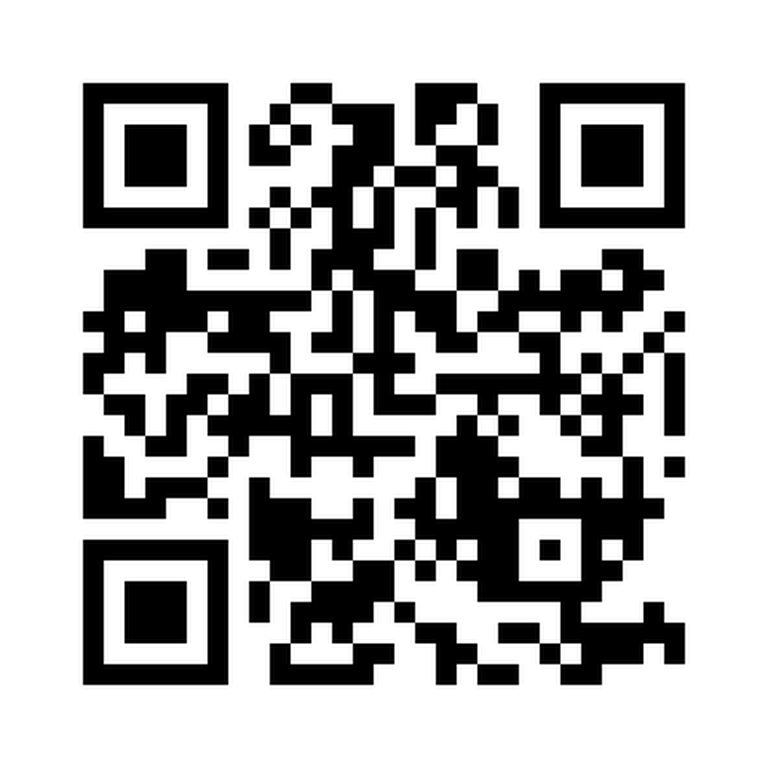

In [6]:
qr_code_content = "https://www.launchpad.ai" # Input your Website URL
qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_H,
            box_size=10,
            border=4,
)
qr.add_data(qr_code_content)
qr.make(fit=True)
qrcode_image = qr.make_image(fill_color="black", back_color="white")
qrcode_image = resize_for_condition_image(qrcode_image, 768)
qrcode_image

In [7]:
controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v1p_sd15", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/135 [00:00<?, ?it/s]

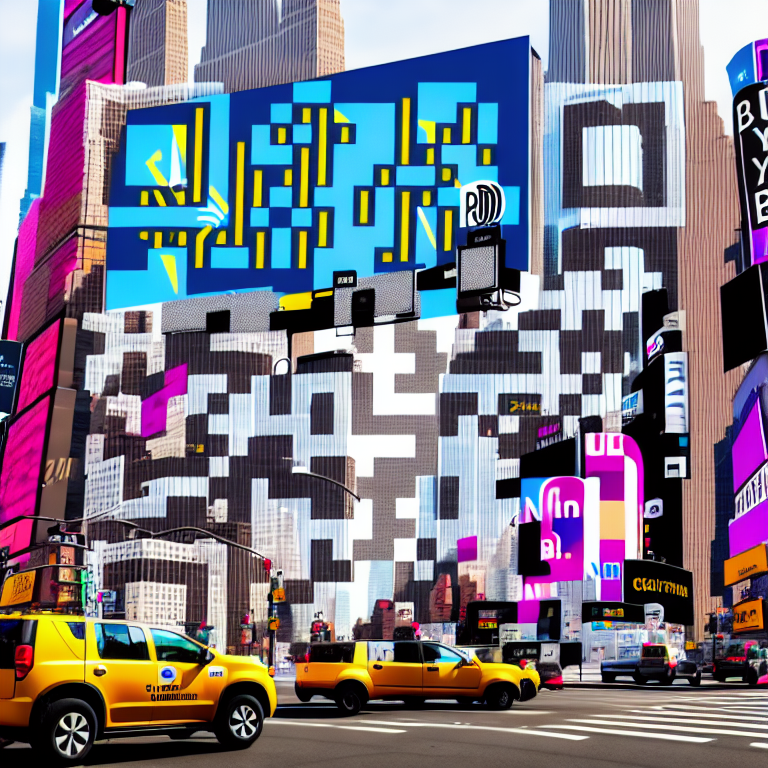

In [9]:
# qr code image
source_image = qrcode_image
# initial image, anything
init_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/noauth/KfMBABpOwIuNolv1pe3qX.jpeg")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="a bilboard in NYC with a qrcode",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=20,
             controlnet_conditioning_scale=1.5,
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
            )

image.images[0]